# Download dependency and import Libraries

In [1]:
# !pip install pyspellchecker

In [2]:
import re, statistics
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
# import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler


import nltk
import string

nltk.download('wordnet', download_dir='/tmp/nltk_data')
nltk.download('stopwords', download_dir='/tmp/nltk_data')
nltk.download('averaged_perceptron_tagger', download_dir='/tmp/nltk_data')
!unzip -n /tmp/nltk_data/corpora/wordnet.zip -d /tmp/nltk_data/corpora/

# Specify the location of the NLTK data
nltk.data.path.append('/tmp/nltk_data')

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.metrics import distance


from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

Archive:  /tmp/nltk_data/corpora/wordnet.zip


[nltk_data] Downloading package wordnet to /tmp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /tmp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Data and perform EDA

In [3]:
# INPUT_DIR = '/kaggle/input/llm-detect-ai-generated-text'
INPUT_DIR = 'data'
train_prompts_df = pd.read_csv(f'{INPUT_DIR}/train_prompts.csv')
train_prompts_df.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [4]:
train_essays_df = pd.read_csv(f'{INPUT_DIR}/train_essays.csv')
print(train_essays_df['prompt_id'].value_counts())
print(train_essays_df['generated'].value_counts())
train_essays_df.head()

0    708
1    670
Name: prompt_id, dtype: int64
0    1375
1       3
Name: generated, dtype: int64


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [5]:
test_essays_df = pd.read_csv(f'{INPUT_DIR}/test_essays.csv')
test_essays_df.head()
# train_essays_df.shape # (1378, 4)
# test_essays_df.shape # (3, 3) Dummy 

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [6]:
sample_submission_df = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sample_submission_df.head()

,id,generated
0,0000aaaa,0.1
1,1111bbbb,0.9
2,2222cccc,0.4


In [7]:
train_essays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB


In [8]:
PaLM_df = pd.read_csv(f'{INPUT_DIR}/LLM_generated_essay_PaLM.csv')
PaLM_df.head()

,id,prompt_id,text,generated
0,0,0.0,## The Advantages of Limiting Car Usage\n\nIn ...,1.0
1,1,0.0,"The United States is a car-dependent nation, w...",1.0
2,2,0.0,"In recent years, there has been a growing move...",1.0
3,3,0.0,"In recent years, there has been a growing move...",1.0
4,4,0.0,"In the past few decades, the United States has...",1.0


In [9]:
print(PaLM_df['prompt_id'].value_counts())
print(PaLM_df['generated'].value_counts())

0.0    712
1.0    672
Name: prompt_id, dtype: int64
1.0    1384
Name: generated, dtype: int64


In [10]:
complete_df = pd.concat([train_essays_df, PaLM_df], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
complete_df.head(10)

,id,prompt_id,text,generated
0,4837dc54,0.0,"For decades, society has put a major emphasis ...",0.0
1,1382,1.0,"Dear Senator,\n\nI am writing to you today to ...",1.0
2,f64490e0,1.0,"Dear Florida State Senator, I am sorry to anno...",0.0
3,758,1.0,"Dear Senator,\n\nI am writing to you today to ...",1.0
4,6479d145,1.0,The Electoral College has been around since th...,0.0
5,9441e668,0.0,Since the 1950's everyone's dream was to have ...,0.0
6,3fa4498e,1.0,"Dear state senator, There has been an ongoing ...",0.0
7,592,0.0,## The Advantages of Limiting Car Usage\n\nIn ...,1.0
8,47e743a7,0.0,The extensive use of car transportation is set...,0.0
9,1135,1.0,"Dear Senator,\n\nI am writing to you today to ...",1.0


In [11]:
print(complete_df['prompt_id'].value_counts())
print(complete_df['generated'].value_counts())

0.0    1420
1.0    1342
Name: prompt_id, dtype: int64
1.0    1387
0.0    1375
Name: generated, dtype: int64


## Feature Engineering

In [12]:
# Define a function to get the wordnet tag from the part-of-speech tag
def get_wordnet_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Define a function to check the spelling of a word
def check_spelling(word):
    # Check if the word is in the English dictionary
    stop_words = set(stopwords.words('english'))

    # Exclude punctuation and numeric values
    if word in string.punctuation or word.isnumeric():
        return True

    # Check if the word is a stop word
    if word.lower() in stop_words:
        return True

    if wordnet.synsets(word):
        return True

    # Otherwise, check the edit distance between the word and its closest match
    else:
        closest = wordnet.morphy(word)
        if closest:
            return distance.edit_distance(word, closest) <= 1
        else:
            return False

import re
import nltk
from nltk.tokenize import sent_tokenize

def tokenize_by_punctuation(sentence):
    # Use regular expression to tokenize by any punctuation
    tokens = re.split(r'[,:;?!]', sentence)
    # Remove empty strings from the result
    tokens = [token.strip() for token in tokens if token.strip()]
    return tokens

# Define a function to check the punctuation of a sentence
def check_punctuation(sentence):
    # Split the sentence by punctuation
    segments = tokenize_by_punctuation(sentence)

    # If there are more than one segment, check the punctuation rules
    if len(segments) > 1:
        # Loop through the segments
        for i in range(len(segments) - 1):
            # Get the punctuation mark between the segments
            mark = sentence[sentence.index(segments[i]) + len(segments[i])]
            
            # Get the next segment
            next_segment = segments[i + 1]

            # If the punctuation mark is a comma, check if the next segment is a coordinating conjunction
            if mark == ",":
                # Define a list of coordinating conjunctions
                conjunctions = ["and", "but", "or", "nor", "for", "yet", "so"]
                # If the next segment is not a conjunction, the comma is likely misplaced
                if not nltk.word_tokenize(next_segment.strip().lower())[0] in conjunctions:
                    return False
                # If the next segment does not have a subject and a verb, the comma is likely misplaced
                tags = nltk.pos_tag(nltk.word_tokenize(next_segment))
                if not ("NN" in tags or "NNS" in tags or "NNP" in tags or "NNPS" in tags) and not ("VB" in tags or "VBD" in tags or "VBG" in tags or "VBN" in tags or "VBP" in tags or "VBZ" in tags):
                    return False
            # If the punctuation mark is a colon, check if the next segment is a complete sentence
            elif mark == ":":
                # If the next segment does not have a subject and a verb, the colon is likely misplaced
                tags = nltk.pos_tag(nltk.word_tokenize(next_segment))
                if not ("NN" in tags or "NNS" in tags or "NNP" in tags or "NNPS" in tags) and not ("VB" in tags or "VBD" in tags or "VBG" in tags or "VBN" in tags or "VBP" in tags or "VBZ" in tags):
                    return False
            # If the punctuation mark is a semicolon, check if the next segment is a complete sentence
            elif mark == ";":
                # If the next segment does not have a subject and a verb, the semicolon is likely misplaced
                tags = nltk.pos_tag(nltk.word_tokenize(next_segment))
                if not ("NN" in tags or "NNS" in tags or "NNP" in tags or "NNPS" in tags) and not ("VB" in tags or "VBD" in tags or "VBG" in tags or "VBN" in tags or "VBP" in tags or "VBZ" in tags):
                    return False
            # If the punctuation mark is a question mark, check if the sentence is a question
            elif mark == "?":
                # Define a list of question words
                question_words = ["who", "what", "where", "when", "why", "how", "which", "whose", "whom", "can", "do", "does"]
                # If the sentence does not have a verb in the first position or a question word in any position, the question mark is likely misplaced
                tags = nltk.pos_tag(nltk.word_tokenize(sentence))
                if not (tags[0][1].startswith("V") or any(tag[0].lower() in question_words for tag in tags)):
                    return False
            # If the punctuation mark is an exclamation mark, check if the sentence is an exclamation
            elif mark == "!":
                # Define a list of exclamatory words
                exclamatory_words = ["wow", "ouch", "yay", "oops", "ugh", "oh", "ah", "eh", "hmm", "no", "yes"]
                # If the sentence does not start with an exclamatory word, the exclamation mark is likely misplaced
                if not nltk.word_tokenize(sentence.strip().lower())[0] in exclamatory_words:
                    return False
    # If there are no punctuation errors, return True
    return True

# Define a function to generate features about a text
def generate_features(text):
    # Initialize the feature dictionary
    features = {}

    # Split the text into paragraphs
    paragraphs = text.split('\n\n')  # Assuming paragraphs are separated by two newline characters

    # Count the number of paragraphs
    features['paragraph_count'] = len(paragraphs)
    
    total_word_count, total_sentence_count, total_spelling_errors, total_punctuation_errors, total_collocations = 0, 0 , 0, 0, 0

    # Initialize lists to store values for calculating means
    sentence_counts = []
    word_counts = []
    spelling_errors = []
    punctuation_errors = []
    collocations = []
    most_common_word_frequencies = []
    
    # Apply word filter to remove stopwords and short words
    stopset = set(stopwords.words('english'))
    filter_stops = lambda w: len(w) < 3 or w in stopset

    # Loop through the paragraphs
    for i, paragraph in enumerate(paragraphs):
        # Split the paragraph into sentences
        sentences = nltk.sent_tokenize(paragraph)

        # Count the number of sentences in the paragraph
        sentence_counts.append(len(sentences))

        # Loop through the sentences
        for j, sentence in enumerate(sentences):
            # Tokenize the sentence into words
            words = nltk.word_tokenize(sentence)

            # Count the number of words in the sentence
            word_counts.append(len(words))

            # Tag the words with their part-of-speech
            tagged = nltk.pos_tag(words)

            # Lemmatize the words with their wordnet tag
            lemmatizer = nltk.stem.WordNetLemmatizer()
            lemmatized = [lemmatizer.lemmatize(word, get_wordnet_tag(tag)) for word, tag in tagged]

            # Count the number of spelling errors in the sentence
            spelling_errors.extend([not check_spelling(word) for word in words])

            # Check the punctuation of the sentence
            if not check_punctuation(sentence):
                # If the sentence has punctuation errors, add it to the list
                punctuation_errors.append(f'Punctuation error in paragraph {i+1}, sentence {j+1}: {sentence}')

            # Create a text object from the lemmatized words
            text_obj = nltk.Text(lemmatized)
            
            words_ = [w.lower() for w in sentence.split()]
            
            bigram_collocation = BigramCollocationFinder.from_words(words_)
            bigram_collocation.apply_word_filter(filter_stops)

            # Set a threshold for likelihood ratio 
            threshold = 10.0

            # Get the bigrams with likelihood ratio above the threshold
            significant_bigrams = [bigram for bigram, score in bigram_collocation.score_ngrams(BigramAssocMeasures.likelihood_ratio) if score > threshold]
            if significant_bigrams:
                collocations.extend(significant_bigrams)
                            
            # Find the collocations of the text
            # if text_obj.collocations():
            #    collocations.extend(text_obj.collocations())

            # Count the number of spelling errors in the sentence
            features[f'spelling_errors_paragraph_{i+1}_sentence_{j+1}'] = sum([not check_spelling(word) for word in words])

            # Count the number of punctuation errors in the sentence
            features[f'punctuation_errors_paragraph_{i+1}_sentence_{j+1}'] = not check_punctuation(sentence)

        # Calculate mean values for the current paragraph
        len_sentence_count = len(sentence_counts)
        len_word_counts = len(word_counts)
        len_spelling_errors = len(spelling_errors)
        len_punctuation_errors = len(punctuation_errors)
        
        if len_sentence_count == 0: len_sentence_count = 1
        if len_word_counts == 0: len_word_counts = 1
        if len_spelling_errors == 0: len_spelling_errors = 1
        if len_punctuation_errors == 0: len_punctuation_errors = 1
        
        
        features[f'mean_sentence_count_paragraph_{i+1}'] = sum(sentence_counts) / len_sentence_count
        features[f'mean_word_count_paragraph_{i+1}'] = sum(word_counts) / len_word_counts
        features[f'mean_spelling_errors_paragraph_{i+1}'] = sum(spelling_errors) / len_spelling_errors
        features[f'mean_punctuation_errors_paragraph_{i+1}'] = punctuation_errors.count(True) / len_punctuation_errors
        features[f'mean_collocations_paragraph_{i+1}'] = len(collocations) / len_sentence_count

        # Calculate total values for the current paragraph
        features[f'total_spelling_errors_paragraph_{i+1}'] = sum(spelling_errors)
        features[f'total_punctuation_errors_paragraph_{i+1}'] = punctuation_errors.count(True)
        features[f'total_collocations_paragraph_{i+1}'] = len(collocations)
        
        total_word_count +=  sum(word_counts)
        total_sentence_count += sum(sentence_counts)
        total_spelling_errors += sum(spelling_errors)
        total_punctuation_errors += punctuation_errors.count(True)
        total_collocations += len(collocations)
        
        # Reset lists for the next paragraph
        sentence_counts = []
        word_counts = []
        spelling_errors = []
        punctuation_errors = []
        collocations = []

    total_paragraphs = len(paragraphs)
    features_dict = {
        'paragraph_count': total_paragraphs,
        'word_count': total_word_count,
        'sentence_count': total_sentence_count,
        'spelling_errors': total_spelling_errors,
        'punctuation_errors': total_punctuation_errors,
        'collocations': total_collocations
    }
        
    # Calculate overall mean values
    features_dict['mean_sentence_count'] = sum(features.get(f'mean_sentence_count_paragraph_{i+1}', 0) for i in range(total_paragraphs)) / total_paragraphs if total_paragraphs > 0 else 0
    features_dict['mean_word_count'] = sum(features.get(f'mean_word_count_paragraph_{i+1}', 0) for i in range(total_paragraphs)) / total_paragraphs if total_paragraphs > 0 else 0
    features_dict['mean_spelling_errors'] = sum(features.get(f'mean_spelling_errors_paragraph_{i+1}', 0) for i in range(total_paragraphs)) / total_paragraphs if total_paragraphs > 0 else 0
    features_dict['mean_punctuation_errors'] = sum(features.get(f'mean_punctuation_errors_paragraph_{i+1}', 0) for i in range(total_paragraphs)) / total_paragraphs if total_paragraphs > 0 else 0
    features_dict['mean_collocations'] = sum(features.get(f'mean_collocations_paragraph_{i+1}', 0) for i in range(total_paragraphs)) / total_paragraphs if total_paragraphs > 0 else 0

    return features_dict

In [16]:
complete_df["features"] = complete_df['text'].apply(generate_features)
complete_df = pd.concat([complete_df.drop(['features'], axis=1), complete_df['features'].apply(pd.Series)], axis=1)
complete_df.head()

,id,prompt_id,text,generated,paragraph_count,word_count,sentence_count,spelling_errors,punctuation_errors,collocations,mean_sentence_count,mean_word_count,mean_spelling_errors,mean_punctuation_errors,mean_collocations
0,4837dc54,0.0,"For decades, society has put a major emphasis ...",0.0,5.0,744.0,30.0,37.0,0.0,0.0,6.000000,25.360714,0.048981,0.0,0.000000
1,1382,1.0,"Dear Senator,\n\nI am writing to you today to ...",1.0,8.0,281.0,17.0,1.0,0.0,0.0,2.125000,15.208333,0.005952,0.0,0.000000
2,f64490e0,1.0,"Dear Florida State Senator, I am sorry to anno...",0.0,3.0,735.0,32.0,111.0,0.0,2.0,10.666667,22.754762,0.150815,0.0,0.666667
3,758,1.0,"Dear Senator,\n\nI am writing to you today to ...",1.0,9.0,504.0,27.0,4.0,0.0,0.0,3.000000,15.209259,0.005047,0.0,0.000000
4,6479d145,1.0,The Electoral College has been around since th...,0.0,5.0,718.0,28.0,57.0,0.0,6.0,5.600000,24.028889,0.076697,0.0,1.200000


# Split Dataset into Train and Test

In [17]:
additional_features = ['paragraph_count', 'word_count', 'sentence_count', 'spelling_errors', 
                        'punctuation_errors', 'collocations', 'mean_sentence_count', 
                        'mean_word_count', 'mean_spelling_errors', 'mean_punctuation_errors', 
                        'mean_collocations']

Complete_required_df = complete_df[additional_features + ['id', 'text', 'generated']]
X_train_required_df, X_test_required_df, y_train_required_df, y_test_required_df = train_test_split(
    Complete_required_df[additional_features + ['text']], Complete_required_df['generated'],
    test_size=0.2,  
    stratify=complete_df['generated'],
    random_state=42  
)

print(X_train_required_df.shape, y_train_required_df.shape)
print(X_test_required_df.shape, y_test_required_df.shape)

(2209, 12) (2209,)
(553, 12) (553,)


In [18]:
X_train_required_df.head()

,paragraph_count,word_count,sentence_count,spelling_errors,punctuation_errors,collocations,mean_sentence_count,mean_word_count,mean_spelling_errors,mean_punctuation_errors,mean_collocations,text
2070,5.0,754.0,35.0,52.0,0.0,0.0,7.000,21.151429,0.064626,0.0,0.0,Limiting the usage of cars will bring a lot of...
1213,12.0,556.0,33.0,15.0,0.0,0.0,2.750,14.520833,0.014303,0.0,0.0,## The Advantages of Limiting Car Usage\n\nCar...
424,8.0,450.0,27.0,6.0,0.0,0.0,3.375,18.311012,0.010465,0.0,0.0,"In recent years, there has been a growing move..."
485,8.0,487.0,32.0,9.0,0.0,0.0,4.000,14.987500,0.017310,0.0,0.0,"In the United States, we are a car-centric soc..."
999,5.0,634.0,25.0,19.0,0.0,0.0,5.000,25.360000,0.030384,0.0,0.0,There are many fellow citizens in the world th...


In [19]:
print(y_train_required_df.value_counts())
print(y_test_required_df.value_counts())

1.0    1109
0.0    1100
Name: generated, dtype: int64
1.0    278
0.0    275
Name: generated, dtype: int64


# Distibution and Plots between Features and Target

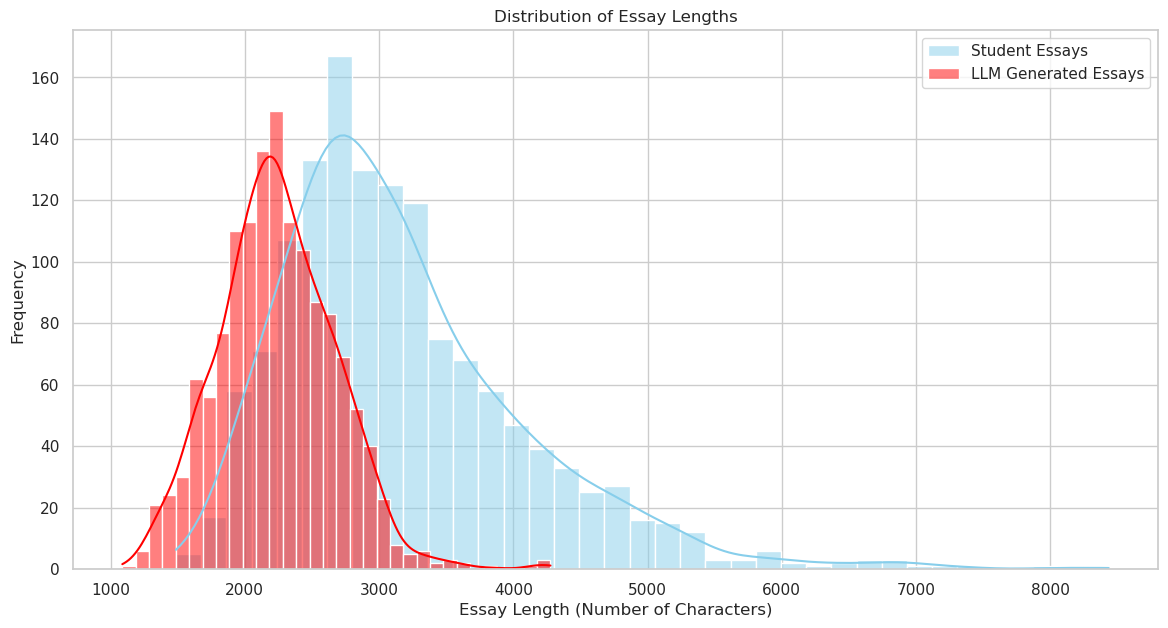

In [20]:
# Calculate the length of each essay and create a new column
complete_df['essay_length'] = complete_df['text'].apply(len)

sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

# Distribution of essay lengths for student essays
sns.histplot(complete_df[complete_df['generated'] == 0]['essay_length'], color="skyblue", label='Student Essays', kde=True)

# Distribution of essay lengths for LLM generated essays
sns.histplot(complete_df[complete_df['generated'] == 1]['essay_length'], color="red", label='LLM Generated Essays', kde=True)

plt.title('Distribution of Essay Lengths')
plt.xlabel('Essay Length (Number of Characters)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

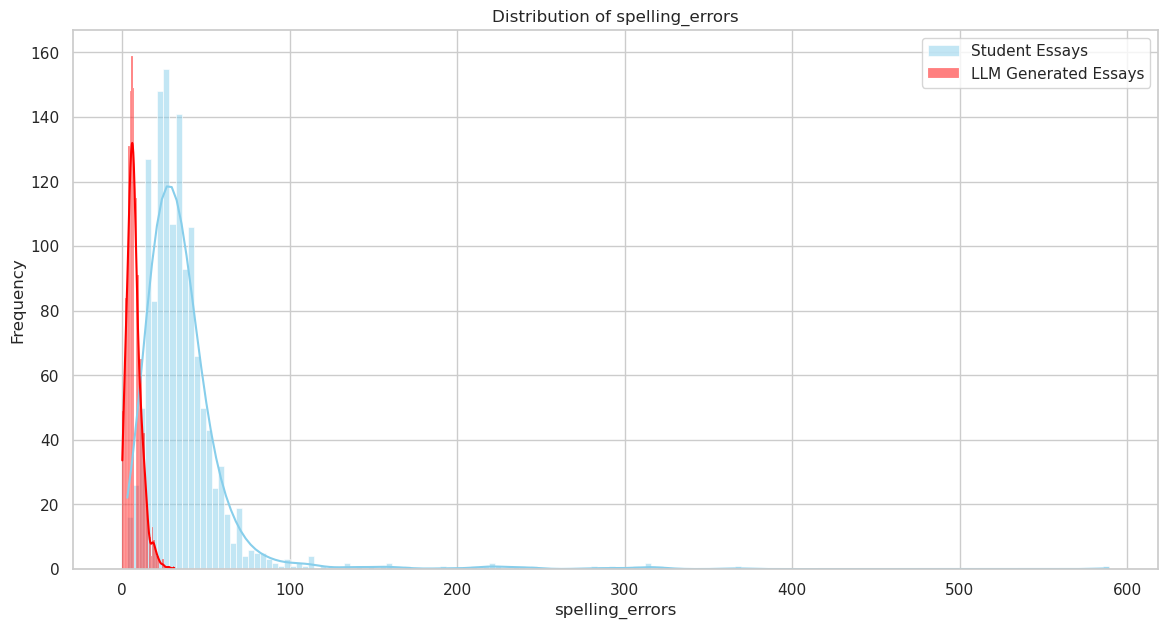

In [21]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

# Distribution of spelling_errors for student essays
sns.histplot(complete_df[complete_df['generated'] == 0]['spelling_errors'], color="skyblue", label='Student Essays', kde=True)

# Distribution of spelling_errors for LLM generated essays
sns.histplot(complete_df[complete_df['generated'] == 1]['spelling_errors'], color="red", label='LLM Generated Essays', kde=True)

plt.title('Distribution of spelling_errors')
plt.xlabel('spelling_errors')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Correlation between engineered features and Target

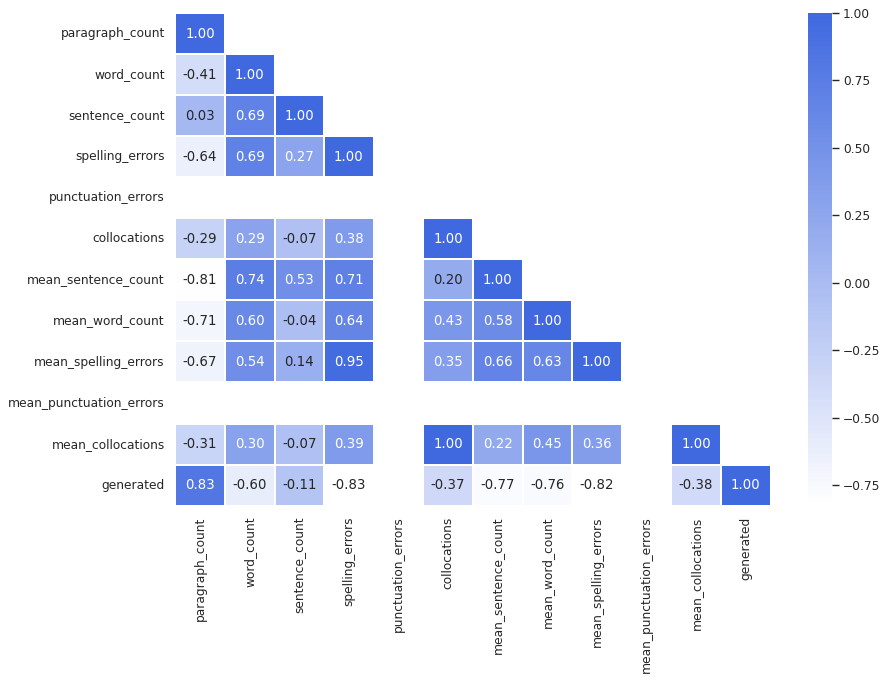

In [22]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Define a colormap
royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
royalblue_r = royalblue.reversed()

target = 'generated'
numeric_columns = additional_features + ['generated']
complete_df_numeric = complete_df[numeric_columns]

complete_df_numeric_ordered = pd.concat([complete_df_numeric.drop(target,axis=1), complete_df_numeric[target]],axis=1)

corr = complete_df_numeric_ordered.corr(method='spearman')

# Create a mask so that we see the correlation values only once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)] = True

# Plot the heatmap correlation
plt.figure(figsize=(12,8), dpi=80)
sns.heatmap(corr, mask=mask, annot=True, cmap=royalblue, fmt='.2f', linewidths=0.2)
plt.show()

In [23]:
sns.set_palette(['royalblue', 'darkturquoise'])

Num_Features = additional_features + ['generated']

fig, ax = plt.subplots(len(Num_Features), 2, figsize=(30,75), dpi=200, gridspec_kw={'width_ratios': [1, 2]})
target = 'generated'


for i,col in enumerate(Num_Features):
    # barplot
    graph = sns.barplot(data=complete_df_numeric, x=target, y=col, ax=ax[i,0])
    # kde Plot
    sns.kdeplot(data=complete_df_numeric[complete_df_numeric[target]<=0.5], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0.0')
    sns.kdeplot(data=complete_df_numeric[complete_df_numeric[target]>=0.5], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1.0')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='generated', loc='upper right')
    # Add bar sizes to our plot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')

plt.suptitle('Numerical Features vs Target Distribution', fontsize=22)
plt.tight_layout()
plt.show()

/tmp/ipykernel_578676/2633114021.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=complete_df_numeric[complete_df_numeric[target]<=0.5], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0.0')
/tmp/ipykernel_578676/2633114021.py:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=complete_df_numeric[complete_df_numeric[target]>=0.5], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1.0')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_578676/2633114021.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=complete_df_numeric[complete_df_numeric[target]<=0.5], x=col, fill=True, linewidth=2, ax=ax[i,1]

In [24]:
complete_df['collocations'].value_counts()

0.0     2072
1.0      327
2.0       84
11.0      24
12.0      23
3.0       22
9.0       17
17.0      17
6.0       15
8.0       14
14.0      13
10.0      13
7.0       13
13.0      12
5.0       11
4.0       11
15.0       8
19.0       7
18.0       6
20.0       6
21.0       5
16.0       4
25.0       4
26.0       4
34.0       3
29.0       3
35.0       2
22.0       2
36.0       2
23.0       2
46.0       2
32.0       2
43.0       1
47.0       1
31.0       1
30.0       1
41.0       1
40.0       1
54.0       1
27.0       1
55.0       1
60.0       1
37.0       1
45.0       1
Name: collocations, dtype: int64

# Performing TF-IDF to populate training Dataframe

In [25]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=50000)
X_train_text = vectorizer.fit_transform(X_train_required_df['text'])

X_train_required_df.reset_index(drop= True, inplace=True)

# Combine text data with additional features
X_train = pd.concat([pd.DataFrame(X_train_text.toarray()), X_train_required_df[additional_features]], axis=1)
X_train.shape

(2209, 14759)

In [26]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,word_count,sentence_count,spelling_errors,punctuation_errors,collocations,mean_sentence_count,mean_word_count,mean_spelling_errors,mean_punctuation_errors,mean_collocations
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,754.0,35.0,52.0,0.0,0.0,7.000,21.151429,0.064626,0.0,0.0
1,0.0,0.043247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,556.0,33.0,15.0,0.0,0.0,2.750,14.520833,0.014303,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,450.0,27.0,6.0,0.0,0.0,3.375,18.311012,0.010465,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,487.0,32.0,9.0,0.0,0.0,4.000,14.987500,0.017310,0.0,0.0
4,0.0,0.033585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,634.0,25.0,19.0,0.0,0.0,5.000,25.360000,0.030384,0.0,0.0


# Scaling Training features and Using Logistic Regression

In [27]:
lr_model = LogisticRegression(max_iter=1000)
cv = StratifiedKFold(n_splits=5, shuffle=True)
auc_scores = []

X_train.columns = X_train.columns.astype(str)
column_order = X_train.columns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [28]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=column_order)
X_train_scaled_df.head()

,0,1,2,3,4,5,6,7,8,9,...,word_count,sentence_count,spelling_errors,punctuation_errors,collocations,mean_sentence_count,mean_word_count,mean_spelling_errors,mean_punctuation_errors,mean_collocations
0,-0.061978,-0.366716,-0.021281,-0.021281,-0.021281,-0.021281,-0.021281,-0.021281,-0.021281,-0.021281,...,1.371504,1.147595,1.000856,0.0,-0.301073,1.184007,0.225476,0.794897,0.0,-0.284989
1,-0.061978,1.737648,-0.021281,-0.021281,-0.021281,-0.021281,-0.021281,-0.021281,-0.021281,-0.021281,...,0.179865,0.876758,-0.234558,0.0,-0.301073,-0.751143,-0.885902,-0.512425,0.0,-0.284989
2,-0.061978,-0.366716,-0.021281,-0.021281,-0.021281,-0.021281,-0.021281,-0.021281,-0.021281,-0.021281,...,-0.458084,0.064246,-0.535064,0.0,-0.301073,-0.466562,-0.250616,-0.612131,0.0,-0.284989
3,-0.061978,-0.366716,-0.021281,-0.021281,-0.021281,-0.021281,-0.021281,-0.021281,-0.021281,-0.021281,...,-0.235403,0.741339,-0.434896,0.0,-0.301073,-0.181981,-0.807683,-0.434303,0.0,-0.284989
4,-0.061978,1.267496,-0.021281,-0.021281,-0.021281,-0.021281,-0.021281,-0.021281,-0.021281,-0.021281,...,0.649299,-0.206592,-0.101000,0.0,-0.301073,0.273348,0.930890,-0.094672,0.0,-0.284989


In [29]:
X_train_scaled_df.shape

(2209, 14759)

# Fitting the training data with validation

In [30]:
for train_idx, val_idx in cv.split(X_train, y_train_required_df):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_required_df.iloc[train_idx], y_train_required_df.iloc[val_idx]

    lr_model.fit(X_train_fold, y_train_fold)

    preds_val_lr = lr_model.predict_proba(X_val_fold)[:, 1]

    auc_score = roc_auc_score(y_val_fold, preds_val_lr)
    auc_scores.append(auc_score)

for i, score in enumerate(auc_scores, 1):
    print(f'ROC AUC for fold {i}: {score:.4f}')

print('Average ROC AUC:', round(sum(auc_scores)/len(auc_scores), 4))
print('Standard deviation:', round((sum([(x - sum(auc_scores)/len(auc_scores))**2 for x in auc_scores])/len(auc_scores))**0.5, 4))

ROC AUC for fold 1: 0.9996
ROC AUC for fold 2: 0.9998
ROC AUC for fold 3: 0.9994
ROC AUC for fold 4: 0.9963
ROC AUC for fold 5: 0.9957
Average ROC AUC: 0.9982
Standard deviation: 0.0018


# Preprocessing Testing data

In [31]:
X_test_text = vectorizer.transform(X_test_required_df['text'])

X_test_required_df.reset_index(drop= True, inplace=True)

X_test = pd.concat([pd.DataFrame(X_test_text.toarray()), X_test_required_df[additional_features]], axis=1)

X_test.columns = X_test.columns.astype(str)

X_test_scaled = scaler.transform(X_test)

X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=column_order)

In [32]:
X_test_scaled_df.shape

(553, 14759)

# Predicting the testing Data from the fitted Model

In [33]:
test_preds = lr_model.predict(X_test_scaled_df)

In [34]:
# Predict probabilities for the positive class on the test data
test_probs = lr_model.predict_proba(X_test_scaled_df)[:, 1]

# Calculate ROC AUC score for the test set
roc_auc = roc_auc_score(y_test_required_df, test_probs)

print('ROC AUC on Test Set:', round(roc_auc, 4))

ROC AUC on Test Set: 0.9325


# Computing Metrics for Evaluation

In [35]:
y_true = y_test_required_df

# Confusion matrix
conf_matrix = confusion_matrix(y_true, test_preds)

# Extracting TP, FP, FN, TN
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TN = conf_matrix[0, 0]

# Other metrics
accuracy = accuracy_score(y_true, test_preds)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Confusion Matrix:")
print(conf_matrix)
print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, test_preds))


Confusion Matrix:
[[251  24]
 [112 166]]

Metrics:
Accuracy: 0.7541
Precision: 0.8737
Recall: 0.5971
F1 Score: 0.7094

Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.91      0.79       275
         1.0       0.87      0.60      0.71       278

    accuracy                           0.75       553
   macro avg       0.78      0.75      0.75       553
weighted avg       0.78      0.75      0.75       553



ROC AUC: 0.9325


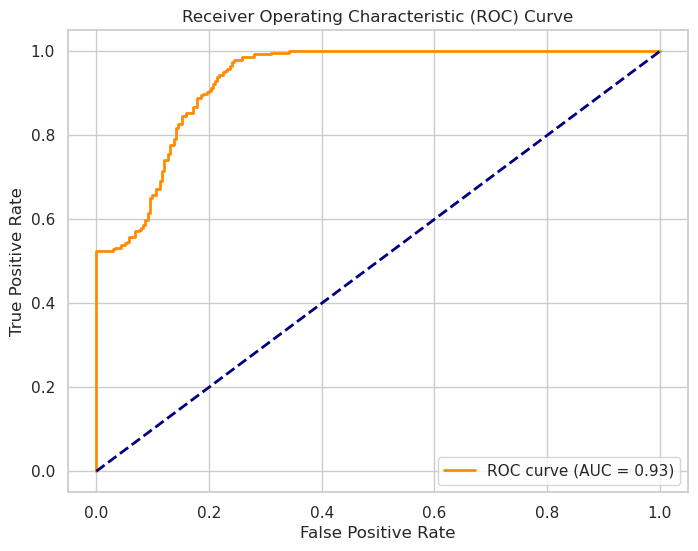

In [36]:
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, test_probs)
roc_auc = auc(fpr, tpr)

print(f"ROC AUC: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Test and Submission

In [37]:
# Preprocessing Test Data
test_essays_df["features"] = test_essays_df['text'].apply(generate_features)
test_essays_df = pd.concat([test_essays_df.drop(['features'], axis=1), test_essays_df['features'].apply(pd.Series)], axis=1)
test_essays_df.head()

,id,prompt_id,text,paragraph_count,word_count,sentence_count,spelling_errors,punctuation_errors,collocations,mean_sentence_count,mean_word_count,mean_spelling_errors,mean_punctuation_errors,mean_collocations
0,0000aaaa,2,Aaa bbb ccc.,1.0,4.0,1.0,1.0,0.0,0.0,1.0,4.0,0.25,0.0,0.0
1,1111bbbb,3,Bbb ccc ddd.,1.0,4.0,1.0,2.0,0.0,0.0,1.0,4.0,0.50,0.0,0.0
2,2222cccc,4,CCC ddd eee.,1.0,4.0,1.0,2.0,0.0,0.0,1.0,4.0,0.50,0.0,0.0


In [38]:
submission_df = test_essays_df[['id']]
test_essays_df = test_essays_df[additional_features + ['text']]

In [39]:
# Pipeline to change test data to feed into model
X_submission_text = vectorizer.transform(test_essays_df['text'])

test_essays_df.reset_index(drop= True, inplace=True)

X_submission = pd.concat([pd.DataFrame(X_submission_text.toarray()), test_essays_df[additional_features]], axis=1)

X_submission.columns = X_submission.columns.astype(str)

X_submission_scaled = scaler.transform(X_submission)

X_submission_scaled_df = pd.DataFrame(X_submission_scaled, columns=column_order)

In [40]:
test_probs = lr_model.predict_proba(X_submission_scaled_df)[:, 1]

In [41]:
submission_df['generated'] = test_probs
submission_df.head()

,id,generated
0,0000aaaa,0.043795
1,1111bbbb,0.039471
2,2222cccc,0.039471


In [42]:
submission_df.to_csv('submission.csv', index=False)